In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import plot_tree, plot_importance
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
import graphviz

from sklearn.cross_validation import train_test_split
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#model = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05)

In [108]:
df = pd.read_csv("data/data_with_added_dummies.csv")

In [109]:
y = df["y"]
cols_to_remove_from_features = ["y", "campaign"]
X = df[[col for col in df.columns.tolist() if col not in cols_to_remove_from_features]]

df["y"].mean()

0.11698480458295547

In [110]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.05, stratify=train_y, random_state=42)

In [10]:

params = {"obj": "reg:logistic", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1, 'eval_metric': 'auc'}#, 'scale_pos_weight' = sum_wneg/sum_wpos}
num_rounds = 500


dtrain = xgb.DMatrix(tr_X, label=tr_y)
dval = xgb.DMatrix(val_X, label=val_y)
watchlist  = [(dval,'eval'), (dtrain,'train')]
bst = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)
#gbdt = xgb.train(xgb_params, dtrain, num_rounds, early_stopping_rounds=10)

[0]	eval-auc:0.854557	train-auc:0.883746
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.854769	train-auc:0.884473
[2]	eval-auc:0.869316	train-auc:0.905862
[3]	eval-auc:0.871537	train-auc:0.906351
[4]	eval-auc:0.87334	train-auc:0.90767
[5]	eval-auc:0.873252	train-auc:0.907707
[6]	eval-auc:0.887378	train-auc:0.917643
[7]	eval-auc:0.887732	train-auc:0.918717
[8]	eval-auc:0.891482	train-auc:0.920258
[9]	eval-auc:0.89161	train-auc:0.92037
[10]	eval-auc:0.893105	train-auc:0.920468
[11]	eval-auc:0.894042	train-auc:0.92082
[12]	eval-auc:0.89374	train-auc:0.92123
[13]	eval-auc:0.893179	train-auc:0.921384
[14]	eval-auc:0.893267	train-auc:0.921329
[15]	eval-auc:0.894133	train-auc:0.922107
[16]	eval-auc:0.894204	train-auc:0.92228
[17]	eval-auc:0.894315	train-auc:0.922612
[18]	eval-auc:0.893713	train-auc:0.923232
[19]	eval-auc:0.893778	train-auc:0.923617
[20]	eval-auc:0.894037	train-auc:0.

In [11]:
feature_imp = bst.get_fscore()

In [12]:
def plot_feature_importance(feature_imp):
    N = len(feature_imp)
    jet = plt.get_cmap('jet')
    plt.barh(range(N), feature_imp.values(), align='center', color=jet(np.linspace(0, 1.0, N)))
    x_labels = feature_imp.keys()
    plt.yticks(range(N), x_labels, fontsize=6)

In [13]:
dtest = xgb.DMatrix(test_X, label=test_y)
pred = bst.predict(dtest)

In [44]:
#params = {"obj": "reg:logistic", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1, 'eval_metric': 'auc', 'scale_pos_weight':df["y"].mean()}#, 'scale_pos_weight' = sum_wneg/sum_wpos}
def fit_xgboost(params, train_X, train_y, test_X, test_y, features=None):
    if features is None:
        features = test_X.columns().values
    dtest_X = xgb.DMatrix(test_X[features])
    tr_X, val_X, tr_y, val_y = train_test_split(train_X[features], train_y, test_size=0.05, stratify=train_y, random_state=42)
    num_rounds = 500
    dtrain = xgb.DMatrix(tr_X, label=tr_y)
    dval = xgb.DMatrix(val_X, label=val_y)
    watchlist  = [(dval,'eval'), (dtrain,'train')]
    xgb_model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)
    feature_imp = xgb_model.get_fscore()
    plot_feature_importance(feature_imp)
    #roc + auc
    pred = xgb_model.predict(dtest_X)
    fpr, tpr, thresholds = roc_curve(test_y, pred)
    plt.plot(fpr,tpr)
    plt.show() 
    model_auc = auc(fpr,tpr)
    print "auc: {0}".format(model_auc) 
    plot_importance(model)
    return xgb_model

In [15]:
# xgboost with weighting
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.05, stratify=train_y)
params = {"obj": "reg:logistic", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1, 'eval_metric': 'auc', 'scale_pos_weight':df["y"].mean()}#, 'scale_pos_weight' = sum_wneg/sum_wpos}
num_rounds = 500


dtrain = xgb.DMatrix(tr_X, label=tr_y)
dval = xgb.DMatrix(val_X, label=val_y)
watchlist  = [(dval,'eval'), (dtrain,'train')]
xgb_weighted = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)
#gbdt = xgb.train(xgb_params, dtrain, num_rounds, early_stopping_rounds=10)

[0]	eval-auc:0.857669	train-auc:0.84895
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.857649	train-auc:0.848972
[2]	eval-auc:0.857649	train-auc:0.848972
[3]	eval-auc:0.857775	train-auc:0.849004
[4]	eval-auc:0.857999	train-auc:0.849186
[5]	eval-auc:0.857517	train-auc:0.849448
[6]	eval-auc:0.857369	train-auc:0.849557
[7]	eval-auc:0.85748	train-auc:0.849569
[8]	eval-auc:0.857608	train-auc:0.850154
[9]	eval-auc:0.857723	train-auc:0.850288
[10]	eval-auc:0.858213	train-auc:0.85162
[11]	eval-auc:0.858087	train-auc:0.851686
[12]	eval-auc:0.858073	train-auc:0.851739
[13]	eval-auc:0.862974	train-auc:0.86035
[14]	eval-auc:0.863318	train-auc:0.860656
[15]	eval-auc:0.863168	train-auc:0.861007
[16]	eval-auc:0.862925	train-auc:0.861164
[17]	eval-auc:0.862957	train-auc:0.861288
[18]	eval-auc:0.863812	train-auc:0.861997
[19]	eval-auc:0.863852	train-auc:0.86201
[20]	eval-auc:0.863923	train-auc

In [16]:
feature_imp_weighted = xgb_weighted.get_fscore()
print feature_imp

{'contact_cellular': 838, 'loan': 838, 'job_management': 661, 'marital_single': 281, 'job_student': 472, 'duration': 15483, 'education': 1843, 'pdays': 5374, 'previous': 1843, 'marital_divorced': 547, 'job_unemployed': 341, 'month_sep': 639, 'contact_telephone': 140, 'month_jan': 406, 'housing': 1727, 'poutcome_failure': 395, 'job_housemaid': 320, 'month_may': 756, 'marital_married': 808, 'poutcome_other': 326, 'job_entrepreneur': 294, 'job_unknown': 130, 'month_mar': 669, 'poutcome_success': 1070, 'poutcome_unknown': 2, 'month_nov': 597, 'month_oct': 940, 'job_retired': 238, 'unknown_education': 669, 'month_jun': 716, 'month_jul': 500, 'job_blue-collar': 547, 'month_aug': 913, 'job_services': 519, 'month_dec': 384, 'job_self-employed': 473, 'day': 8279, 'job_technician': 859, 'default': 231, 'age': 12191, 'month_feb': 943, 'contact_unknown': 558, 'month_apr': 1033, 'balance': 10911, 'job_admin.': 684}


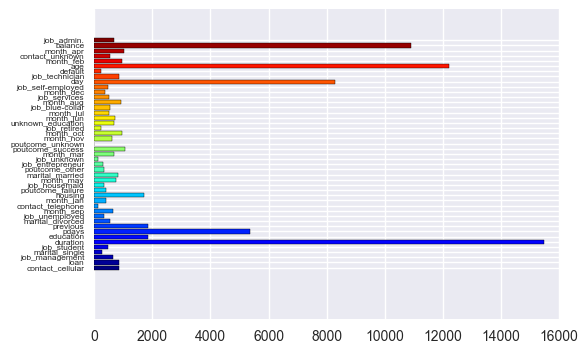

In [17]:
plot_feature_importance(feature_imp)

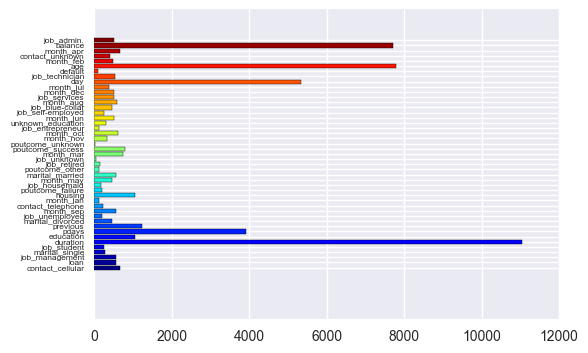

In [18]:
plot_feature_importance(feature_imp_weighted)

[0]	eval-auc:0.820557	train-auc:0.815883
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.820557	train-auc:0.815883
[2]	eval-auc:0.820557	train-auc:0.815891
[3]	eval-auc:0.820557	train-auc:0.815891
[4]	eval-auc:0.820557	train-auc:0.815891
[5]	eval-auc:0.820557	train-auc:0.815891
[6]	eval-auc:0.820557	train-auc:0.815897
[7]	eval-auc:0.820542	train-auc:0.816025
[8]	eval-auc:0.8205	train-auc:0.816036
[9]	eval-auc:0.820994	train-auc:0.816233
[10]	eval-auc:0.821209	train-auc:0.817251
[11]	eval-auc:0.82125	train-auc:0.817285
[12]	eval-auc:0.82125	train-auc:0.817537
[13]	eval-auc:0.825206	train-auc:0.826533
[14]	eval-auc:0.825213	train-auc:0.826558
[15]	eval-auc:0.825361	train-auc:0.826582
[16]	eval-auc:0.82569	train-auc:0.82687
[17]	eval-auc:0.825715	train-auc:0.826906
[18]	eval-auc:0.825919	train-auc:0.826933
[19]	eval-auc:0.825768	train-auc:0.827413
[20]	eval-auc:0.825754	train-auc:

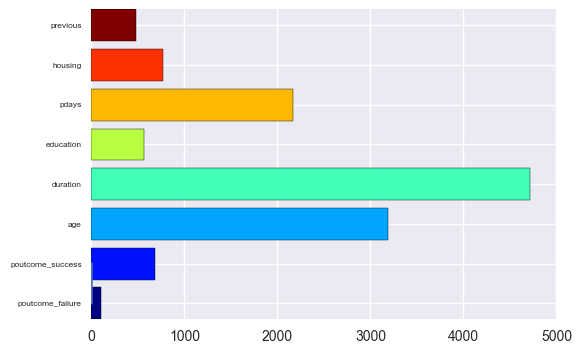

auc: 0.888208587239


In [32]:
# features = ["duration", "education", "pdays", "age", "previous", "housing", "poutcome_success", "poutcome_failure"]
# params = {"obj": "binary:logistic", "eta": 0.01, "max_depth": 5, "seed": 42, "silent": 1, 'eval_metric': 'auc', 'scale_pos_weight':df["y"].mean()}#, 'scale_pos_weight' = sum_wneg/sum_wpos}
# dtest_X = xgb.DMatrix(test_X[features])
# tr_X, val_X, tr_y, val_y = train_test_split(train_X[features], train_y, test_size=0.05, stratify=train_y, random_state=42)


# model = fit_xgboost(params, tr_X, tr_y, val_X, val_y, dtest_X, test_y)

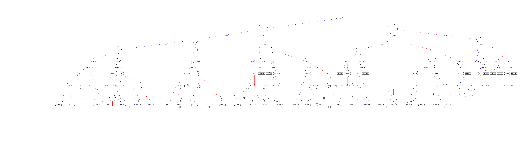

In [29]:
plot_tree(xgb_weighted, num_trees=2)

In [41]:
X.columns.values

array(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'pdays', 'previous', 'unknown_education', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

[0]	eval-auc:0.8213	train-auc:0.816242
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.8213	train-auc:0.816242
[2]	eval-auc:0.8213	train-auc:0.816242
[3]	eval-auc:0.82125	train-auc:0.81625
[4]	eval-auc:0.821191	train-auc:0.816257
[5]	eval-auc:0.821204	train-auc:0.816256
[6]	eval-auc:0.821096	train-auc:0.816264
[7]	eval-auc:0.821096	train-auc:0.816265
[8]	eval-auc:0.821096	train-auc:0.816268
[9]	eval-auc:0.821115	train-auc:0.816404
[10]	eval-auc:0.821341	train-auc:0.817429
[11]	eval-auc:0.821088	train-auc:0.817479
[12]	eval-auc:0.821125	train-auc:0.817717
[13]	eval-auc:0.82495	train-auc:0.826714
[14]	eval-auc:0.825284	train-auc:0.828472
[15]	eval-auc:0.825697	train-auc:0.828543
[16]	eval-auc:0.825898	train-auc:0.828712
[17]	eval-auc:0.825951	train-auc:0.828738
[18]	eval-auc:0.825994	train-auc:0.828737
[19]	eval-auc:0.82596	train-auc:0.82921
[20]	eval-auc:0.825923	train-auc:0.829

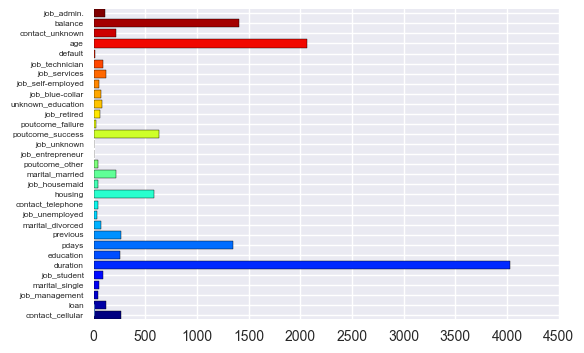

auc: 0.895447530338


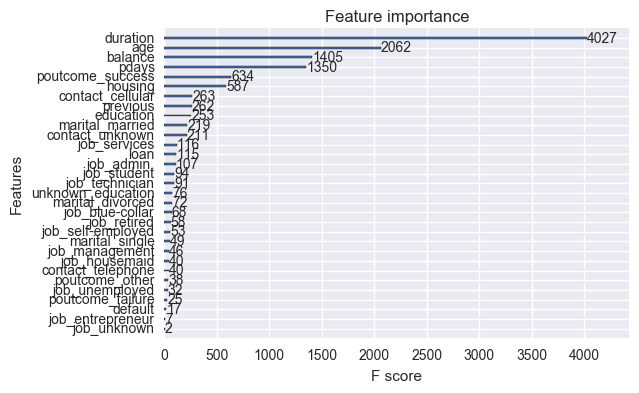

In [45]:
params = {"obj": "binary:logistic", "eta": 0.01, "max_depth": 5, "seed": 42, "silent": 1, 'eval_metric': 'auc', 'scale_pos_weight':df["y"].mean()}#, 'scale_pos_weight' = sum_wneg/sum_wpos}
my_features = ['age', 'education', 'default', 'balance', 'housing', 'loan',
       'duration', 'pdays', 'previous', 'unknown_education', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown']

model = fit_xgboost(params, train_X, train_y, test_X, test_y, my_features)

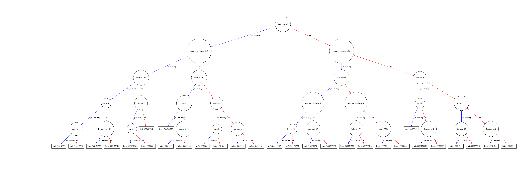

In [53]:
# save xgboost trees
plot_tree(model, num_trees=2)
plt.savefig("graph.png", dpi=500)

In [54]:
df.columns.values

array(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'y',
       'unknown_education', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [55]:
fpr, tpr, thresholds = roc_curve(test_y, pred)

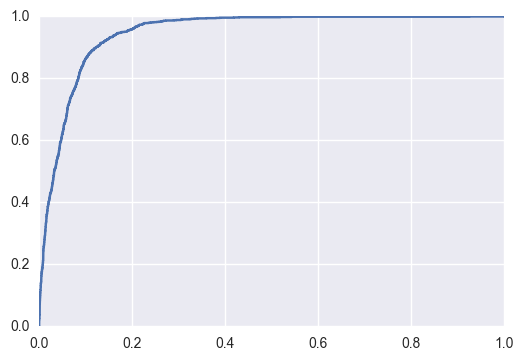

auc: 0.946387281069


In [12]:
plt.plot(fpr,tpr)
plt.show() 

model_auc = auc(fpr,tpr)
print "auc: {0}".format(model_auc) 

In [17]:
pred_weighted = xgb_weighted.predict(dtest)

In [18]:
fpr, tpr, thresholds = roc_curve(test_y, pred)
model_auc = auc(fpr,tpr)
print "auc: {0}".format(model_auc) 

auc: 0.946387281069


In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.lda import LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

/Users/vky565/anaconda/envs/bootcamp/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [122]:
def assess_model(model, train_X, train_y, test_X, test_y):
    print model
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    print "accuracy score: {0}".format(accuracy_score(test_y, predictions))
    print "recall: {0}".format(recall_score(test_y, predictions))
    print "precision: {0}".format(precision_score(test_y, predictions))
    predictions_probs = model.predict_proba(test_X)
    fpr, tpr, thresholds = roc_curve(test_y, predictions_probs[:, 1])
    print "auc: {0}".format(auc(fpr, tpr))
    plt.plot(fpr,tpr)
    plt.show() 
    cur_res_df = pd.DataFrame({"fpr":fpr, "tpr": tpr})
    model_name = model.__class__.__name__
    cur_res_df["model"] = model_name
    return cur_res_df

In [128]:
models = [LogisticRegression(), KNeighborsClassifier(), LDA(), DecisionTreeClassifier(), RandomForestClassifier()]#, SVC(probability=True)]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 0.900911262497
recall: 0.350226928896
precision: 0.639502762431
auc: 0.904219833114


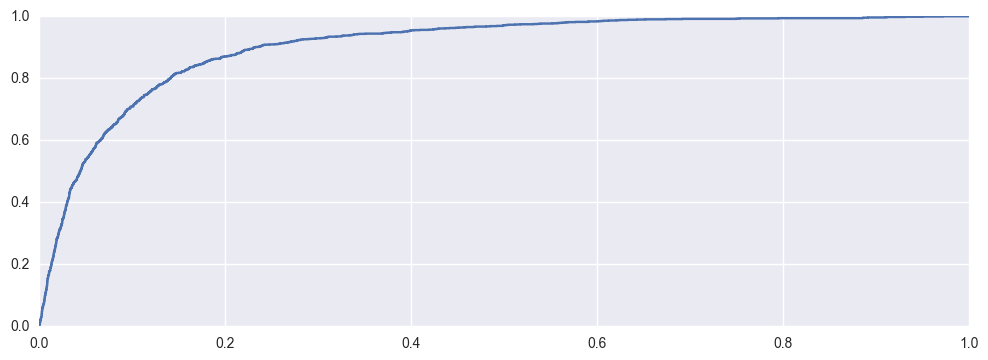

(11303, 45)
(1576, 3)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
accuracy score: 0.880474210387
recall: 0.275340393343
precision: 0.480845442536
auc: 0.757660659641


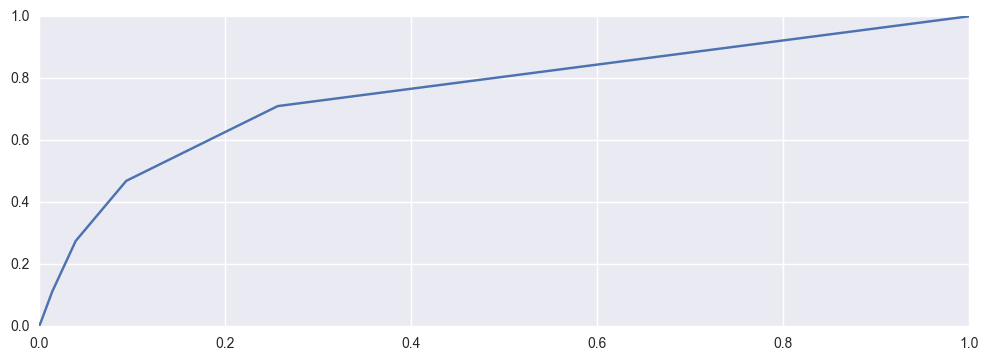

(11303, 45)
(7, 3)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
accuracy score: 0.901442095019
recall: 0.436459909228
precision: 0.609936575053
auc: 0.905095399868


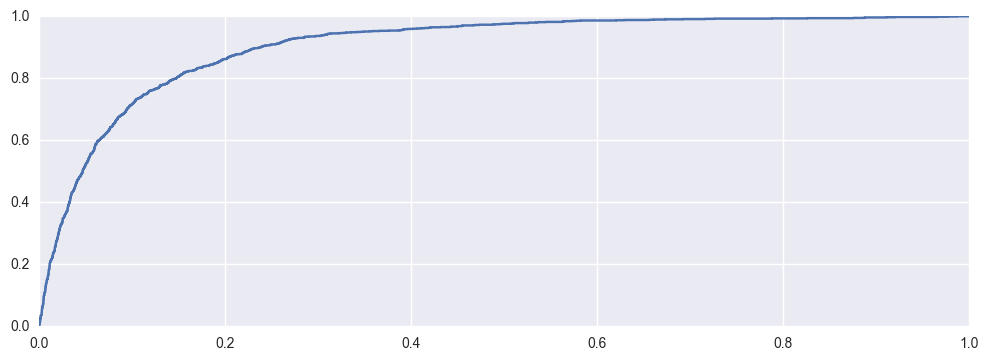

(11303, 45)
(1632, 3)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
accuracy score: 0.87436963638
recall: 0.473524962179
precision: 0.463703703704
auc: 0.700493570158


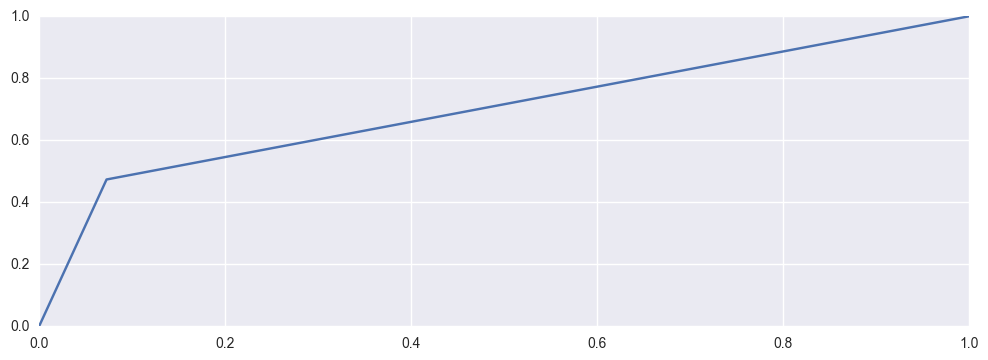

(11303, 45)
(3, 3)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy score: 0.902503760064
recall: 0.368381240545
precision: 0.645888594164
auc: 0.893316097863


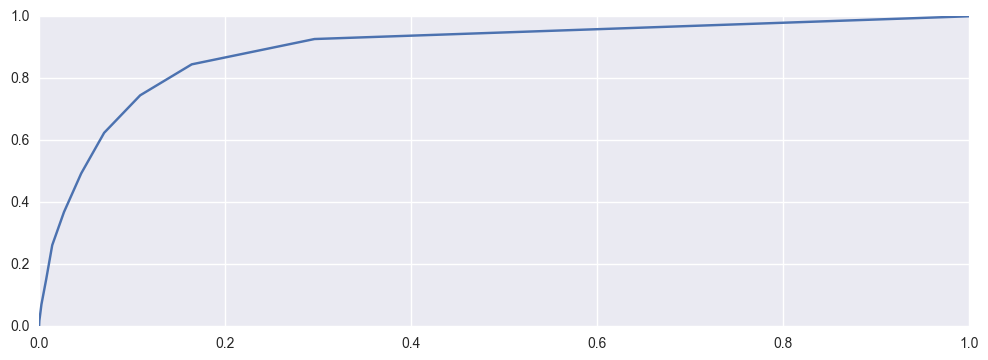

(11303, 45)
(12, 3)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
accuracy score: 0.882951428824
recall: 0.0
precision: 0.0
auc: 0.742406184458


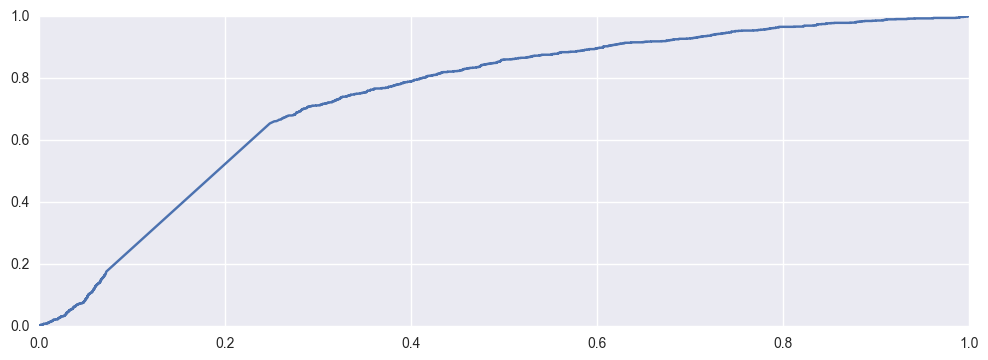

(11303, 45)
(1319, 3)


In [135]:
results_dfs = []
for model in models:
    cur_res = assess_model(model, train_X, train_y, test_X, test_y)
    print test_X.shape
    print cur_res.shape
    results_dfs.append(cur_res)

In [136]:
#result_df = pd.concat([results_dfs], axis=0)
# for el in results_dfs:
#     print el.shape
print train_X.shape

(33908, 45)


In [ ]:
cur_res_df = pd.DataFrame({"fpr":fpr, "tpr": tpr})


In [116]:
cur_res_df.shape


NameError: name 'cur_res_df' is not defined

In [119]:
results_df.model.value_counts()

LinearDiscriminantAnalysis    1632
LogisticRegression            1576
RandomForestClassifier          12
KNeighborsClassifier             7
DecisionTreeClassifier           3
Name: model, dtype: int64

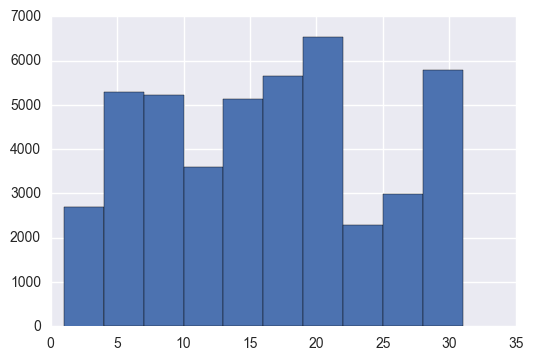

In [56]:
df["day"].hist()

## Clustering

In [63]:
df.columns.values

array(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'y',
       'unknown_education', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [64]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

In [79]:
features_for_clustering = ["age", "education", "balance", "housing","unknown_education", 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown']
df_for_cl = df[features_for_clustering]
my_normalizer = Normalizer()
normalized_data = my_normalizer.fit_transform(df_for_cl)
# kmeans = KMeans(n_clusters=3, random_state=42).fit(normalized_data)
# print kmeans.cluster_centers_
# print "Inertia: {0}".format(kmeans.inertia_)
# print pd.DataFrame(kmeans.cluster_centers_, columns=df_for_cl.columns.values)

In [96]:
def cluster_data(k):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(normalized_data)
    print kmeans.cluster_centers_
    print "Inertia: {0}".format(kmeans.inertia_)
    print pd.DataFrame(kmeans.cluster_centers_, columns=df_for_cl.columns.values)
    return kmeans.inertia_, kmeans

In [93]:
res = []
for k in xrange(1, 10):
    inertia, model = cluster_data(k)
    res.append(inertia)

[[  2.31614260e-01   7.24306814e-02   7.12928409e-01   3.24947608e-03
    2.13946842e-04   5.26425179e-04   2.07821712e-04   1.18977658e-04
    5.08672354e-03]]
Inertia: 19567.5423777
        age  education   balance   housing  unknown_education  \
0  0.231614   0.072431  0.712928  0.003249           0.000214   

   poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown  
0          0.000526        0.000208          0.000119          0.005087  
[[  6.68629084e-01   2.08798580e-01  -3.10369441e-01   9.20719393e-03
    6.07103325e-04   1.34408495e-03   5.56605909e-04   2.47973129e-04
    1.49705900e-02]
 [  1.19585645e-01   3.74728127e-02   9.75250497e-01   1.72221695e-03
    1.13161298e-04   3.16818349e-04   1.18410990e-04   8.59097088e-05
    2.55299742e-03]]
Inertia: 5000.86047315
        age  education   balance   housing  unknown_education  \
0  0.668629   0.208799 -0.310369  0.009207           0.000607   
1  0.119586   0.037473  0.975250  0.001722           0.000113  

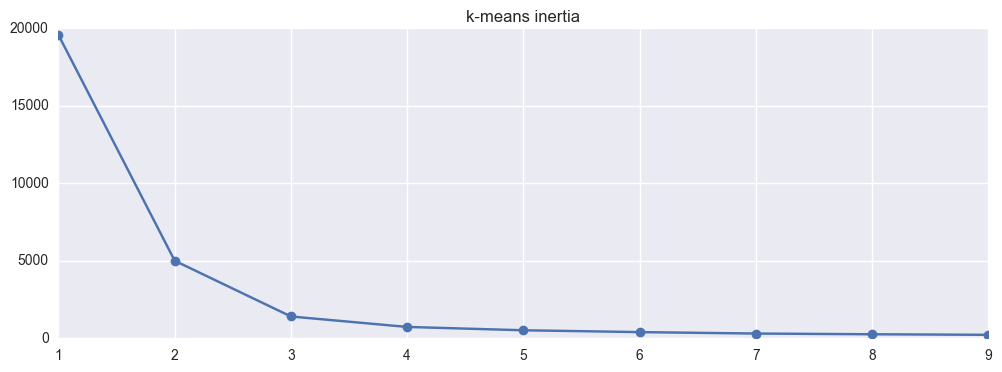

In [95]:
elbow_plt = plt.plot(range(1, 10), res, '-o')
plt.title("k-means inertia")
#plt.show() 
plt.savefig("choose_cluster_number.png")

In [97]:
# chose k = 2
inertia, kmeans = cluster_data(2)

[[  6.68629084e-01   2.08798580e-01  -3.10369441e-01   9.20719393e-03
    6.07103325e-04   1.34408495e-03   5.56605909e-04   2.47973129e-04
    1.49705900e-02]
 [  1.19585645e-01   3.74728127e-02   9.75250497e-01   1.72221695e-03
    1.13161298e-04   3.16818349e-04   1.18410990e-04   8.59097088e-05
    2.55299742e-03]]
Inertia: 5000.86047315
        age  education   balance   housing  unknown_education  \
0  0.668629   0.208799 -0.310369  0.009207           0.000607   
1  0.119586   0.037473  0.975250  0.001722           0.000113   

   poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown  
0          0.001344        0.000557          0.000248          0.014971  
1          0.000317        0.000118          0.000086          0.002553  


In [98]:
df_for_cl["cluster"] = kmeans.predict(normalized_data)

/Users/vky565/anaconda/envs/bootcamp/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [99]:
df_for_cl["cluster"].value_counts()

1    35986
0     9225
Name: cluster, dtype: int64

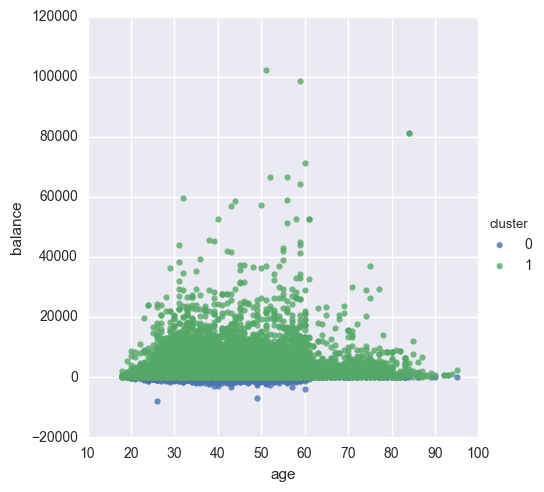

In [103]:
age_edu_plot = sns.lmplot(x="age", y="balance", hue="cluster", data=df_for_cl, fit_reg=False)
age_edu_plot.set_yscale='log'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118dabad0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ad7db90>], dtype=object)

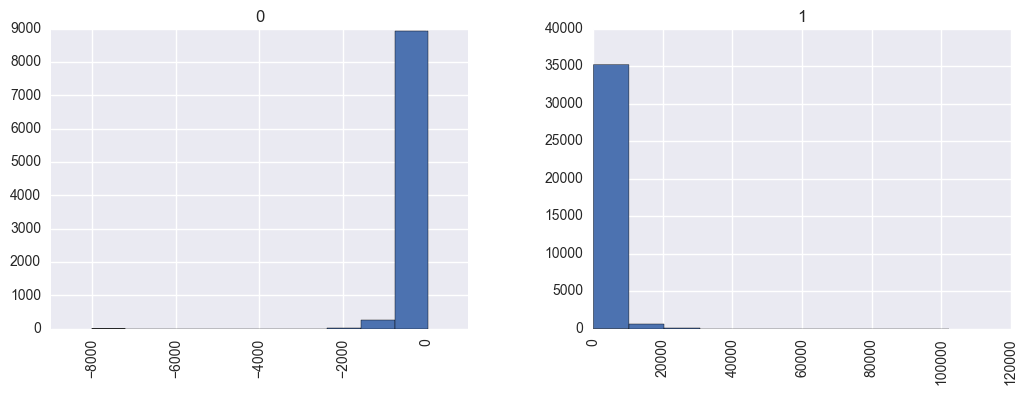

In [105]:
df_for_cl.hist("balance", by="cluster")

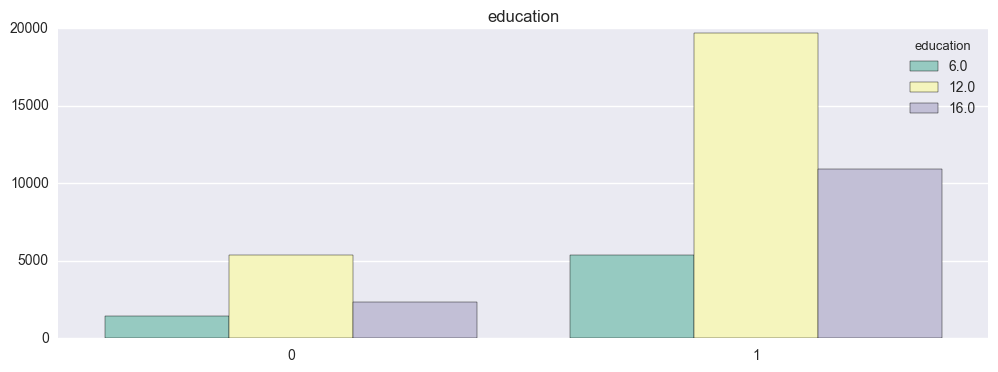

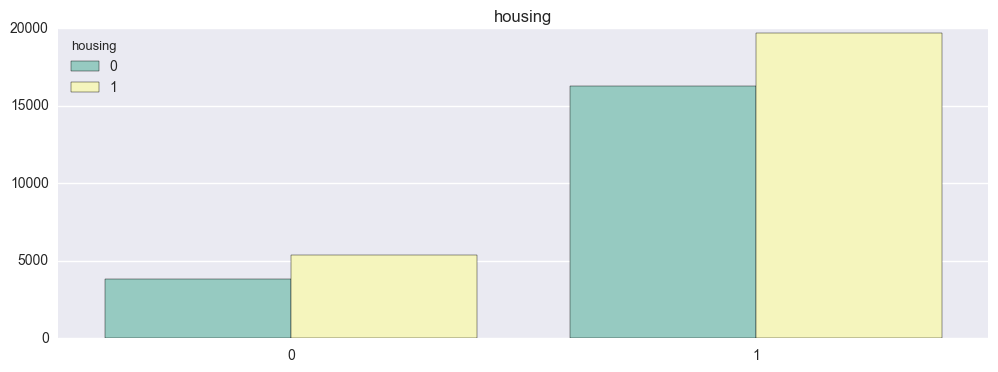

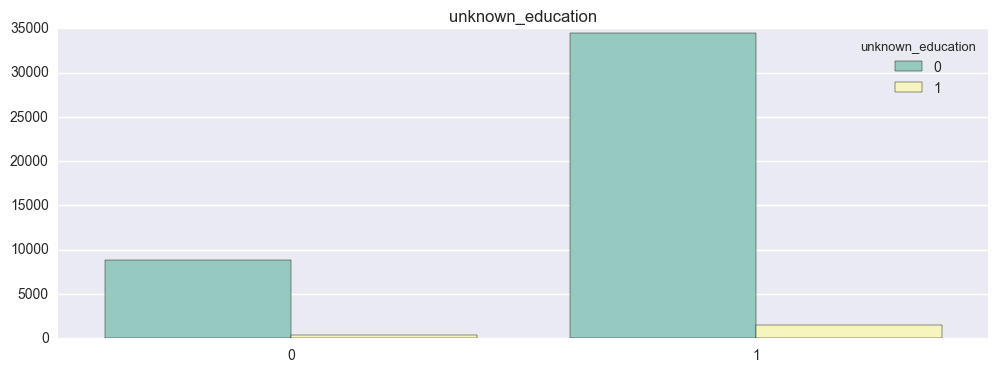

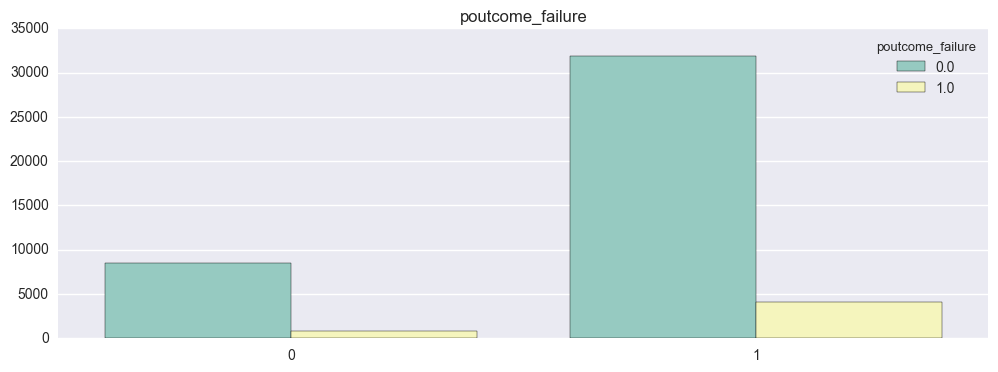

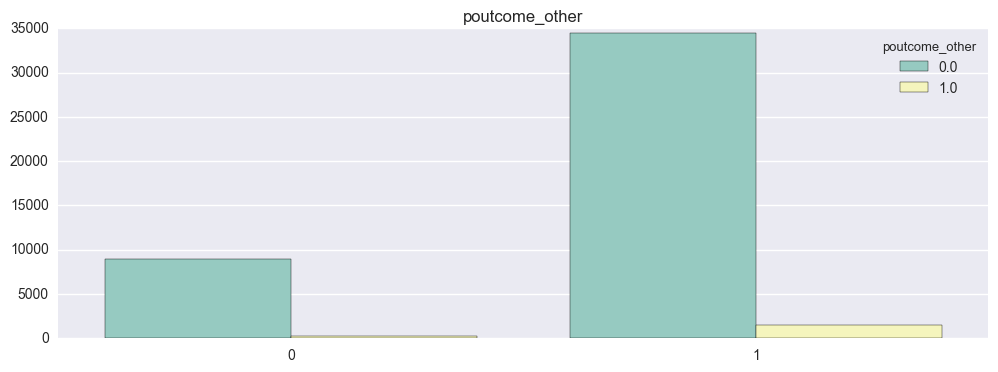

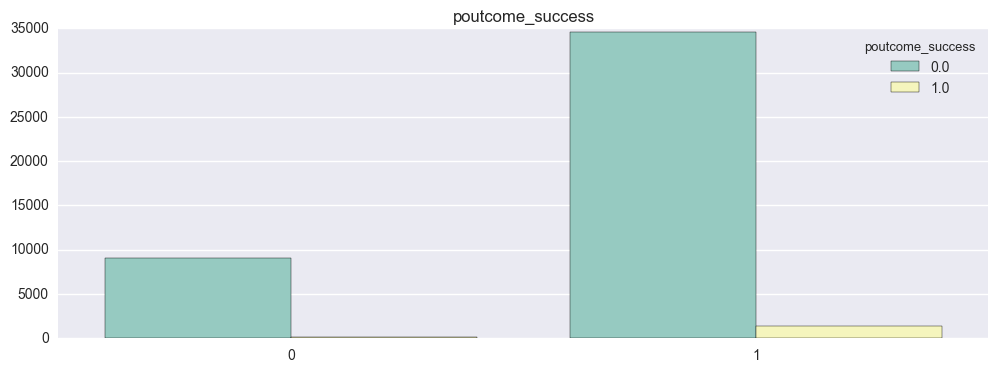

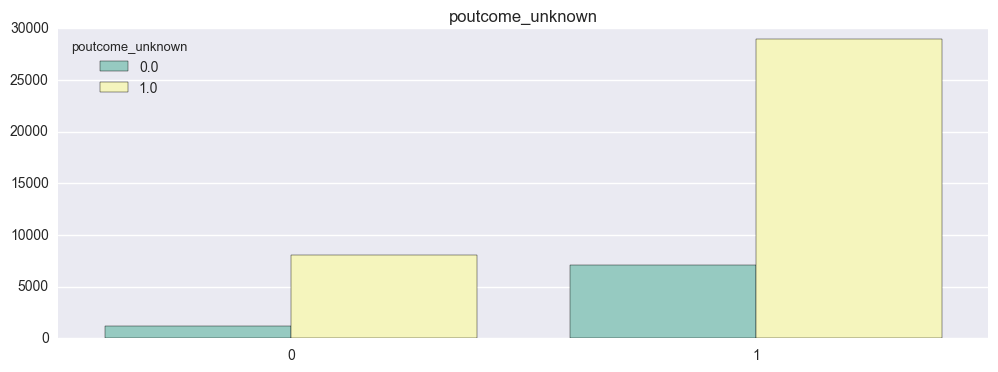

In [106]:
categorical_vars = ['education', 'housing', 'unknown_education', 
                    'poutcome_failure', 'poutcome_other', 'poutcome_success',
                   'poutcome_unknown']
for col in categorical_vars:
    group_plot = sns.countplot(x="cluster", hue=col, data=df_for_cl, palette="Set3")
    group_plot.set(xlabel="", ylabel="")
    group_plot.set_title(col)
    plt.show()

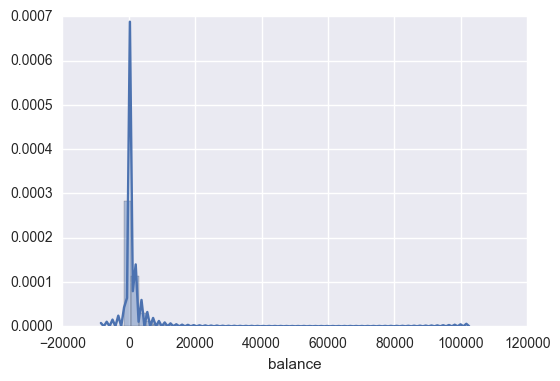

In [100]:
sns.distplot(df["balance"])

In [ ]:
sns.distplot(df["balance"])

In [101]:
df.columns.values

array(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'y',
       'unknown_education', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

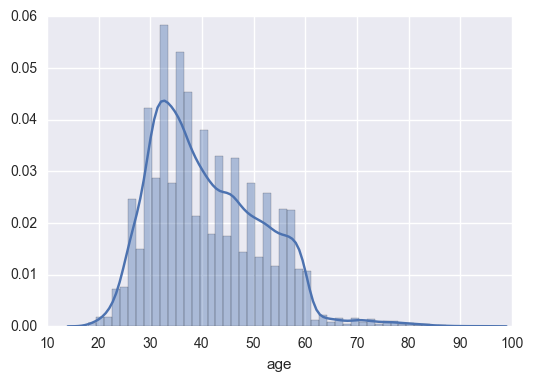

In [102]:
sns.distplot(df["age"])

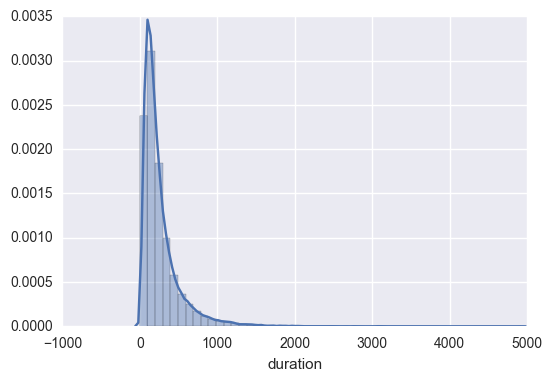

In [103]:
sns.distplot(df["duration"])

In [104]:
df["duration"].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [105]:
df["balance"].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64